In [91]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from os.path import join
from pathlib import Path

from Utils import *

In [92]:
# %% load data
preload = True
data_path = Path(r'..\Midterm Report\data')

# portfolio weights
ETIHX_holdings = pd.read_csv(join(data_path, 'ETIHX_holdings_20191127.csv'))
RYCFX_holdings = pd.read_csv(join(data_path, 'RYCFX_holdings_20190930.csv'))

# asset prices
start_date = dt.date(2020, 1, 1)
end_date = dt.date(2020, 10, 30)
ETIHX_assets = ETIHX_holdings.dropna(subset=['is_valid'])['ticker']
RYCFX_assets = RYCFX_holdings.dropna(subset=['is_valid'])['ticker']

if preload:
    ETIHX_assets = load_file(join(data_path, 'ETIHX_assets_2020.pickle'))
    RYCFX_assets = load_file(join(data_path, 'RYCFX_assets_2020.pickle'))
else:
    ETIHX_assets = get_data_for_multiple_stocks(ETIHX_assets.values, start_date, end_date)
    save_file(join(data_path, 'ETIHX_assets_2020.pickle'), ETIHX_assets)

    RYCFX_assets = get_data_for_multiple_stocks(RYCFX_assets.values, start_date, end_date)
    save_file(join(data_path, 'RYCFX_assets_2020.pickle'), RYCFX_assets)

# optimised weights
optimised_weights = load_file(join(data_path, 'optimised_weights.pickle'))

In [93]:
# %%  get value held for each asset in ETIHX portfolio
ETIHX_log_returns_df = get_df_by_metric(ETIHX_assets, 'log_return')
ETIHX_weights = {}
for ticker in ETIHX_log_returns_df.columns:
    ETIHX_weights[ticker] = ETIHX_holdings[ETIHX_holdings['ticker']==ticker]['value_usd'].values[0]
    
# normalize weights
total_value = sum(ETIHX_weights.values())
for k,v in ETIHX_weights.items():
    ETIHX_weights[k] = v / total_value
    
ETIHX_weights = pd.Series(ETIHX_weights)

assert all(ETIHX_log_returns_df.columns == ETIHX_weights.index)  # check

In [94]:
# %% get value held for each asset in RYCFX portfolio
RYCFX_log_returns_df = get_df_by_metric(RYCFX_assets, 'log_return')
RYCFX_weights = {}

for ticker in RYCFX_log_returns_df.columns:
    RYCFX_weights[ticker] = RYCFX_holdings[RYCFX_holdings['ticker']==ticker]['value_usd'].values[0]
    
# normalize weights
total_value = sum(RYCFX_weights.values())
for k,v in RYCFX_weights.items():
    RYCFX_weights[k] = v / total_value
    
RYCFX_weights = pd.Series(RYCFX_weights)

assert all(RYCFX_log_returns_df.columns == RYCFX_weights.index)  # check

In [95]:
# %% subjective adjustment of optimised weights
adjustment_factor = 0.05
to_increase = ['GLPG', 'NBIX']
to_decrease = ['GWPH', 'CRNX']
adjusted_weights = optimised_weights.copy(deep=True)
adjusted_weights[to_increase] += adjustment_factor
adjusted_weights[to_decrease] -= adjustment_factor
assert np.isclose(1, adjusted_weights.sum(), atol=1e-3)

save_file(join(data_path, 'adjusted_weights.pickle'), adjusted_weights)

In [96]:
# %% evaluate portfolios

# some assets were acquired midway in 2020, need to rebalance portfolio
delisted_assets={'MNTA': dt.date(2020, 8, 19),
                 'AIMT': dt.date(2020, 8, 31)}

portfolios = [(ETIHX_log_returns_df, ETIHX_weights, delisted_assets), (RYCFX_log_returns_df, RYCFX_weights, {}),
              (ETIHX_log_returns_df, optimised_weights, delisted_assets)]

results = pd.DataFrame()
for portfolio in portfolios:
    monthly_return, monthly_risk = evaluate_portfolio(portfolio[0], portfolio[1], portfolio[2])
    results = pd.concat([results, monthly_return, monthly_risk], axis=1)

portfolio_names = ['ETIHX (best)', 'RYCFX (worst)', 'optimised']
col_names = []
for name in portfolio_names:
    col_names.append(f'{name} returns')
    col_names.append(f'{name} risk')

results.columns = col_names

results

,ETIHX (best) returns,ETIHX (best) risk,RYCFX (worst) returns,RYCFX (worst) risk,optimised returns,optimised risk
2020-01-31 00:00:00,-0.066070,0.219172,-0.055371,0.165110,-0.018553,0.237540
2020-02-29 00:00:00,-0.107130,0.343610,0.001263,0.256154,-0.081278,0.312071
2020-03-31 00:00:00,-0.152051,0.985983,-0.044859,0.744576,-0.165284,1.074861
2020-04-30 00:00:00,0.218571,0.486866,0.158550,0.374786,0.193628,0.485705
2020-05-31 00:00:00,0.149412,0.376824,0.076341,0.233925,0.112725,0.348529
2020-06-30 00:00:00,0.053880,0.301752,0.015044,0.247278,0.044326,0.378007
2020-07-31 00:00:00,-0.005222,0.280948,-0.009177,0.198189,-0.064251,0.281944
2020-08-31 00:00:00,0.130362,0.383134,-0.012455,0.183274,0.139941,0.560204
2020-09-30 00:00:00,0.020043,0.290932,-0.022312,0.259846,-0.014829,0.324744
2020-10-31 00:00:00,-0.007925,0.203133,-0.041162,0.235192,-0.031526,0.271133


**Portfolio Returns & Risk**

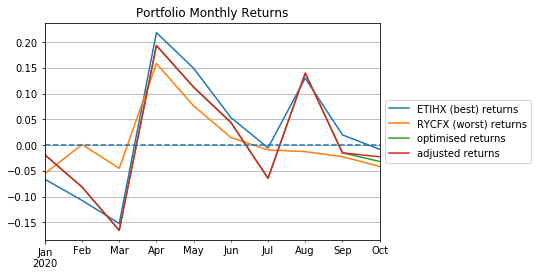

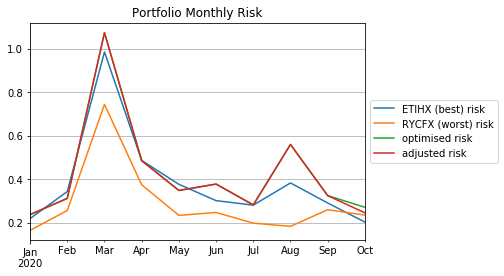

In [97]:
# %% adjust weights in oct 2020
oct_mask = ETIHX_log_returns_df.index >= pd.to_datetime(dt.date(2020, 10, 1))
adj_return, adj_risk = evaluate_portfolio(ETIHX_log_returns_df[oct_mask], adjusted_weights)
adj_return.name = 'adjusted returns'
adj_risk.name = 'adjusted risk'

# merge indexes
optimal_pf_results = results[['optimised returns', 'optimised risk']].merge(adj_return, how='left', left_index=True, right_index=True)
optimal_pf_results = optimal_pf_results.merge(adj_risk, how='left', left_index=True, right_index=True)

# fillna
optimal_pf_results['adjusted returns'] = optimal_pf_results['adjusted returns'].fillna(optimal_pf_results['optimised returns'])
optimal_pf_results['adjusted risk'] = optimal_pf_results['adjusted risk'].fillna(optimal_pf_results['optimised risk'])

results = results.merge(optimal_pf_results[['adjusted returns', 'adjusted risk']], left_index=True, right_index=True)

# compare returns
return_cols = [c for c in results.columns if 'returns' in c]
results[return_cols].plot(title='Portfolio Monthly Returns')
plt.axhline(0, linestyle='--')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# compare risk
risk_cols = [c for c in results.columns if 'risk' in c]
results[risk_cols].plot(title='Portfolio Monthly Risk')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

**get data for index also**

In [98]:
# index
index_data = get_data_for_multiple_stocks(['^NBI'], start_date, end_date)
index_returns = get_df_by_metric(index_data, 'log_return')
index_returns, index_risk = evaluate_portfolio(index_returns, pd.Series([1], index=['^NBI']))

# join with results
results = pd.concat([results, index_returns.rename("index returns"), index_risk.rename("index risk")], axis=1)
results

0/1


,ETIHX (best) returns,ETIHX (best) risk,RYCFX (worst) returns,RYCFX (worst) risk,optimised returns,optimised risk,adjusted returns,adjusted risk,index returns,index risk
2020-01-31,-0.066070,0.219172,-0.055371,0.165110,-0.018553,0.237540,-0.018553,0.237540,-0.056014,0.157669
2020-02-29,-0.107130,0.343610,0.001263,0.256154,-0.081278,0.312071,-0.081278,0.312071,0.003030,0.258611
2020-03-31,-0.152051,0.985983,-0.044859,0.744576,-0.165284,1.074861,-0.165284,1.074861,-0.053831,0.759042
2020-04-30,0.218571,0.486866,0.158550,0.374786,0.193628,0.485705,0.193628,0.485705,0.149690,0.401362
2020-05-31,0.149412,0.376824,0.076341,0.233925,0.112725,0.348529,0.112725,0.348529,0.084488,0.282628
2020-06-30,0.053880,0.301752,0.015044,0.247278,0.044326,0.378007,0.044326,0.378007,0.016056,0.254481
2020-07-31,-0.005222,0.280948,-0.009177,0.198189,-0.064251,0.281944,-0.064251,0.281944,-0.017015,0.229325
2020-08-31,0.130362,0.383134,-0.012455,0.183274,0.139941,0.560204,0.139941,0.560204,0.008998,0.202816
2020-09-30,0.020043,0.290932,-0.022312,0.259846,-0.014829,0.324744,-0.014829,0.324744,-0.001316,0.300350
2020-10-31,-0.007925,0.203133,-0.041162,0.235192,-0.031526,0.271133,-0.022445,0.245439,-0.037303,0.261985


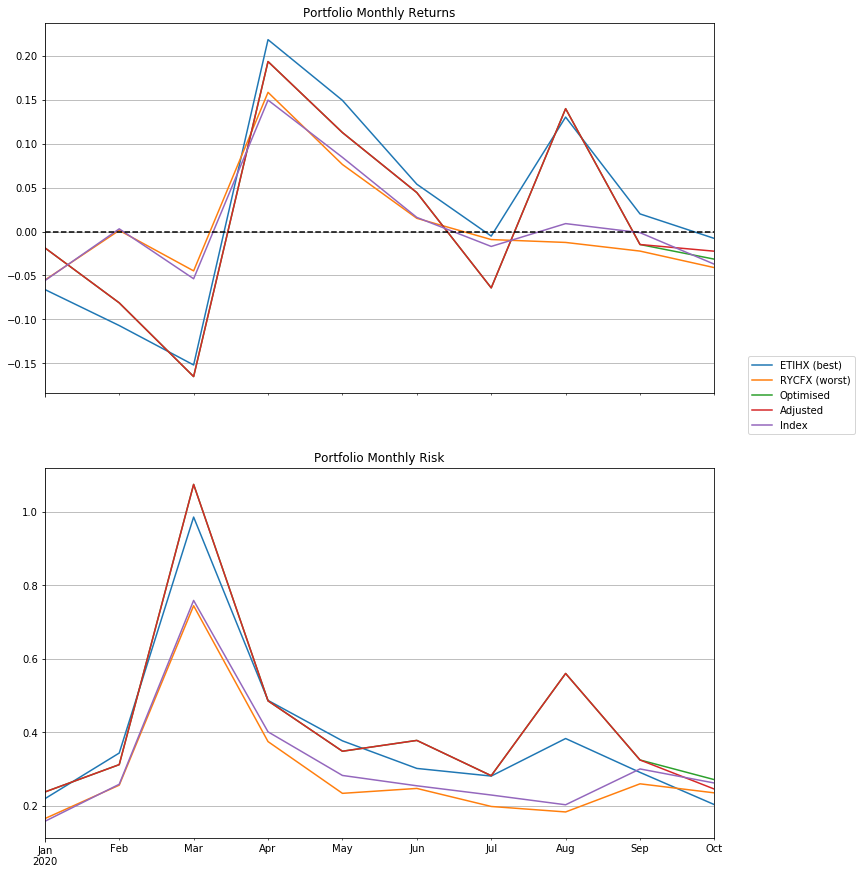

In [99]:
return_cols = [c for c in results.columns if 'return' in c]
risk_cols = [c for c in results.columns if 'risk' in c]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

# compare returns
return_cols = [c for c in results.columns if 'returns' in c]
results[return_cols].plot(title='Portfolio Monthly Returns', figsize=(12, 7), ax=axes[0], legend=False)
axes[0].axhline(0, linestyle='--', color='black')
axes[0].grid(True)

# compare risk
risk_cols = [c for c in results.columns if 'risk' in c]
results[risk_cols].plot(title='Portfolio Monthly Risk', figsize=(12, 15), ax=axes[1], legend=False)
axes[1].grid(True)

plt.legend(['ETIHX (best)', 'RYCFX (worst)', 'Optimised', 'Adjusted', 'Index'],
           bbox_to_anchor=(1.05, 1.3), loc=2, borderaxespad=0.)

In [104]:
# total returns in 2020
return_cols = [c for c in results.columns if 'return' in c]
results[return_cols].apply(lambda x: (x+1).prod() - 1)

ETIHX (best) returns     0.187672
RYCFX (worst) returns    0.048878
optimised returns        0.062488
adjusted returns         0.072451
index returns            0.082247
dtype: float64

In [67]:
results.to_csv('monthly metrics.csv')

**Best / Worst Portfolio after adjustment**

In [114]:
# %% data preprocessing for updated weights

# info report as of 2020-06-30
ETIHX_adj_holdings = pd.read_csv(join(data_path, 'ETIHX_holdings_2020.csv'))
RYCFX_adj_holdings = pd.read_csv(join(data_path, 'RYCFX_holdings_2020.csv'))

start = dt.date(2020, 6, 30)
end = dt.date(2020, 10, 30)
ETIHX_adj_assets = get_data_for_multiple_stocks(ETIHX_adj_holdings['ticker'].dropna(), start, end)
RYCFX_adj_assets = get_data_for_multiple_stocks(RYCFX_adj_holdings['ticker'].dropna(), start, end)

# normalize weights
tmp_ETIHX = ETIHX_adj_holdings.dropna(subset=['ticker'])
ETIHX_adj_weights = tmp_ETIHX['value_usd'] / sum(tmp_ETIHX['value_usd'])
ETIHX_adj_weights.index = ETIHX_adj_holdings['ticker'].dropna()

tmp_RYCFX = RYCFX_adj_holdings.dropna(subset=['ticker'])
RYCFX_adj_weights = tmp_RYCFX['value_usd'] / sum(tmp_RYCFX['value_usd'])
RYCFX_adj_weights.index = RYCFX_adj_holdings['ticker'].dropna()

# calculate returns
ETIHX_adj_log_returns_df = get_df_by_metric(ETIHX_adj_assets, 'log_return')
RYCFX_adj_log_returns_df = get_df_by_metric(RYCFX_adj_assets, 'log_return')

ETIHX_adj_returns, ETIHX_adj_risk = evaluate_portfolio(ETIHX_adj_log_returns_df, ETIHX_adj_weights, delisted_assets)
RYCFX_adj_returns, RYCFX_adj_risk = evaluate_portfolio(RYCFX_adj_log_returns_df, RYCFX_adj_weights, {'IMMU': dt.date(2020, 9, 11)})

0/30
5/30
10/30
15/30
20/30
25/30
0/30
5/30
10/30
15/30
20/30
25/30


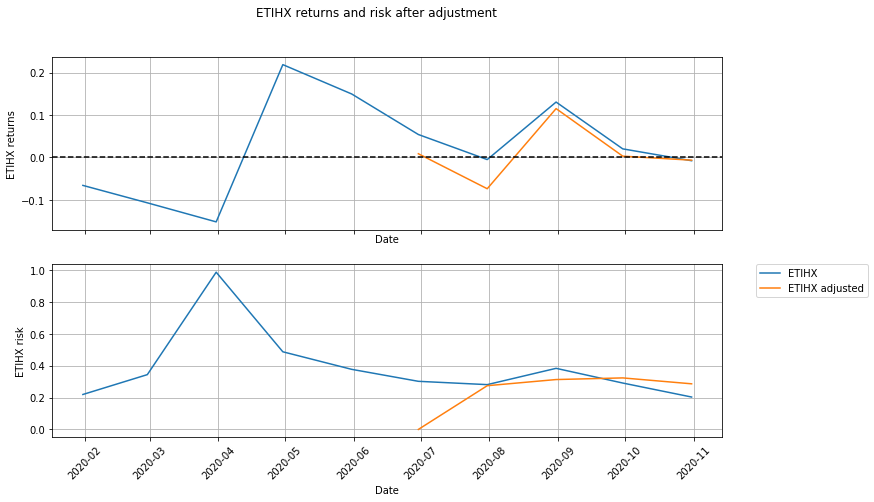

In [27]:
# ETIHX returns
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 7))
axes[0].plot(pd.to_datetime(results.index), results['ETIHX (best) returns'], label='ETIHX')
axes[0].plot(ETIHX_adj_returns.index, ETIHX_adj_returns, label='ETIHX adjusted')
axes[0].grid(True)
axes[0].axhline(0, linestyle='--', color='black')
axes[0].set(xlabel='Date', ylabel='ETIHX returns')

# ETIHX risk
axes[1].plot(pd.to_datetime(results.index), results['ETIHX (best) risk'], label='ETIHX')
axes[1].plot(ETIHX_adj_risk.index, ETIHX_adj_risk, label='ETIHX adjusted')
axes[1].grid(True)
axes[1].set(xlabel='Date', ylabel='ETIHX risk')

fig.suptitle("ETIHX returns and risk after adjustment")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

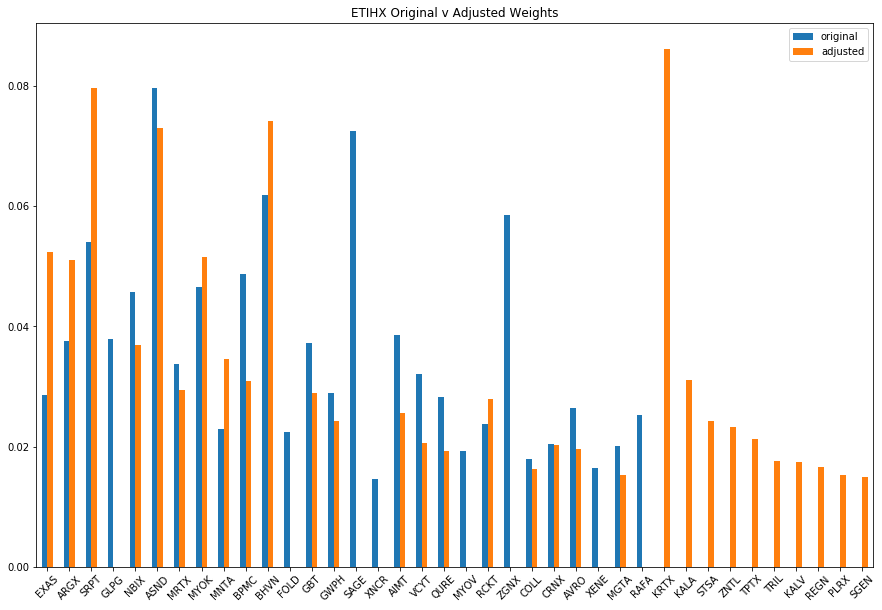

In [129]:
combined_ETIHX = pd.concat([ETIHX_weights, ETIHX_adj_weights], axis=1)
combined_ETIHX.columns = ['original', 'adjusted']
combined_ETIHX.plot(kind='bar', figsize=(15, 10), title='ETIHX Original v Adjusted Weights')
plt.xticks(rotation=45);

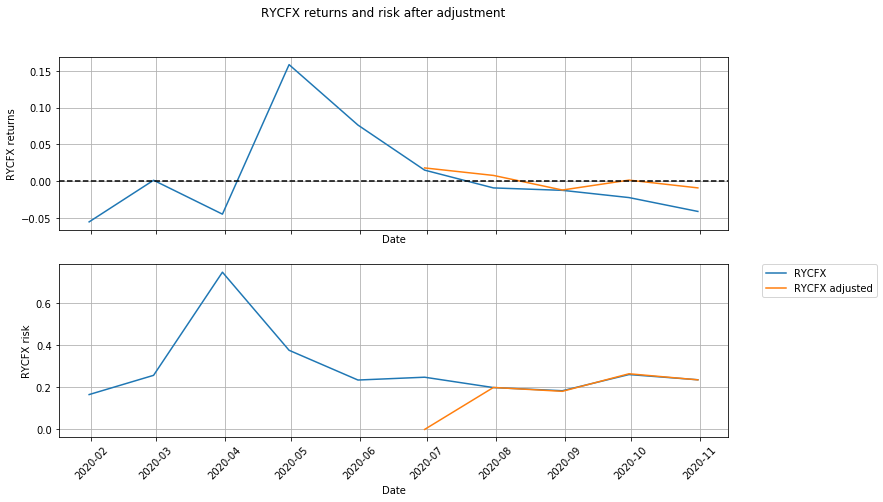

In [29]:
# RYCFX returns
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 7))
axes[0].plot(pd.to_datetime(results.index), results['RYCFX (worst) returns'], label='RYCFX')
axes[0].plot(RYCFX_adj_returns.index, RYCFX_adj_returns, label='RYCFX adjusted')
axes[0].grid(True)
axes[0].axhline(0, linestyle='--', color='black')
axes[0].set(xlabel='Date', ylabel='RYCFX returns')

# RYCFX risk
axes[1].plot(pd.to_datetime(results.index), results['RYCFX (worst) risk'], label='RYCFX')
axes[1].plot(RYCFX_adj_risk.index, RYCFX_adj_risk, label='RYCFX adjusted')
axes[1].grid(True)
axes[1].set(xlabel='Date', ylabel='RYCFX risk')

fig.suptitle("RYCFX returns and risk after adjustment")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

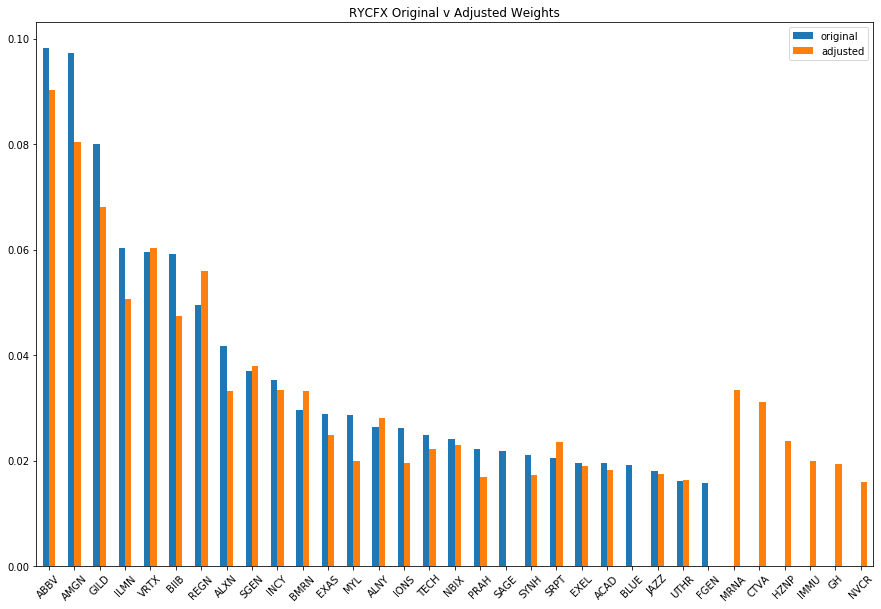

In [130]:
combined_RYCFX = pd.concat([RYCFX_weights, RYCFX_adj_weights], axis=1)
combined_RYCFX.columns = ['original', 'adjusted']
combined_RYCFX.plot(kind='bar', figsize=(15, 10), title='RYCFX Original v Adjusted Weights')
plt.xticks(rotation=45);

**Expected Returns vs Observed Returns**

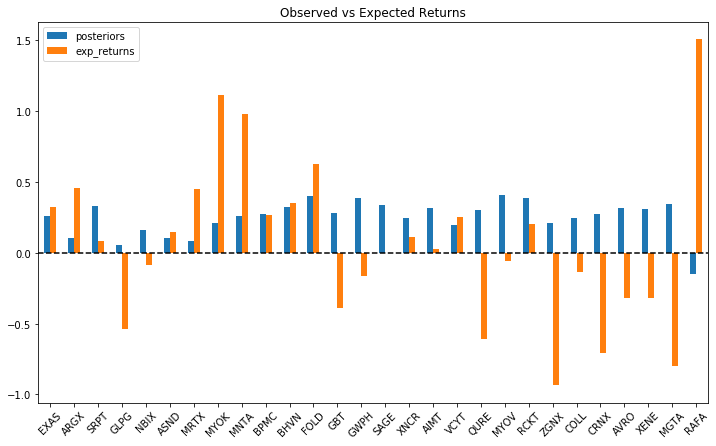

In [31]:
# %% evaluate observed returns vs expected returns
bl_df = load_file(join(data_path, 'bl_df.pickle'))
observed_returns = ETIHX_log_returns_df.sum()
observed_returns.name = 'exp_returns'
compare = bl_df[['posteriors']].merge(observed_returns, how='left', left_index=True, right_index=True)

compare.plot(kind='bar', title='Observed vs Expected Returns', figsize=(12, 7))
plt.axhline(0, linestyle='--', color='black')
plt.xticks(rotation=45)
plt.show()